# Starts here

In [58]:
#These libraries must be installed to be used

!pip install mtcnn        #Face detection
!pip install -U kora      #Displaying video on Colab

In [59]:
#Import inn important libraries

from mtcnn.mtcnn import MTCNN
from IPython.display import HTML
from kora.drive import upload_public
from base64 import b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from moviepy.editor import *
import pandas as pd
from matplotlib.lines import Line2D
import math

labelencoder = LabelEncoder()
detector = MTCNN()





In [60]:
#Display the videos using the play_video function
#Remeber to change the path if you want to test it on a different video

#path1 = '/content/drive/MyDrive/Zoom_5min_1.mp4'    #Middle School

path1 = '/content/drive/MyDrive/Zoom_Old_5min.mp4'   #Elderly  Class

#path1 = '/content/drive/MyDrive/self_made_7min.mp4'   #Self_made  Class


#It will ask for a Google SDK permission, please accpet that aswell
def play_video(path):
  url = upload_public(path1)
  return HTML(f"""<video src={url} width=500 controls/>""")

play_video(path1)

In [61]:
#This function will display all of the people detected on one of the first frames

def show_people(persons, labels):
  amount_of_p = len(persons)
  subplot_each_row = amount_of_p/(2)
  for i in range(len(persons)):
    plt.subplot(2,int(math.ceil(subplot_each_row)),i+1)
    plt.imshow(persons[i])
    plt.xlabel(labels[i])
  #print(labels)
  plt.tight_layout()

#Step One of the Emotion Logger

In [62]:
def video_analysis(path_of_video):
  video = cv2.VideoCapture(path_of_video)
  if (video.isOpened() == False):
    print("Error reading video file")

  frame_width = int(video.get(3))
  frame_height = int(video.get(4))
  size = (frame_width, frame_height)
  frame_num = 0
  i = 0
  list_of_person = []
  list_of_labels = []

  first_frames = 1000             #zoom old = 1000, zoom middle = 60
  
  while ((video.isOpened())):
    ret, frame = video.read()
    frame_num += 1
    if frame_num == first_frames:                          
        location = detector.detect_faces(frame)
        print('Detecting faces............')
        if len(location) > 0:
            i = 0
            for face in location:
                x, y, width, height = face['box']
                x2, y2 = x + width, y + height
                number = 30
                number1 = -20
                image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                image1 = cv2.resize(image[y-number:y2+number,x-number:x2+number],(150,150))
                list_of_person.append(image1)
        if frame_num == first_frames:
            break
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
  video.release()
  cv2.destroyAllWindows()
  if len(list_of_person) != 0:
    #print(yo)
    print('In total there was' ,frame_num, " frames on this video")
    for i in range(len(list_of_person)):
      label_t = names[i].split()[0]
      #print(label_t)
      list_of_labels.append(label_t)
    print(str(len(list_of_labels))+' faces were detected')
  
  list_of_person = np.array(list_of_person)
  list_of_labels = np.array(list_of_labels)
  y1 = labelencoder.fit_transform(list_of_labels)
  #print(y1)
  show_people(list_of_person,list_of_labels)
  return list_of_person, y1,list_of_labels
  print("The video was successfully saved")

Detecting faces............
In total there was 1000  frames on this video
11 faces were detected


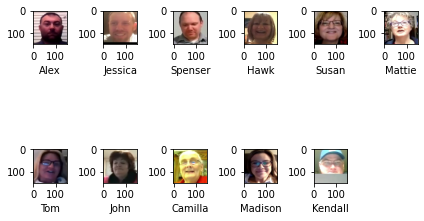

In [63]:

#path = '/content/drive/MyDrive/Zoom_5min_1.mp4'    #Middle School
path = '/content/drive/MyDrive/Zoom_Old_5min.mp4' 
#path = '/content/drive/MyDrive/self_made_7min.mp4'

emotions = ['Angry','Fear','Happy','Neutral','Sad']
emotions = np.array(emotions)
names = ['Alex Baldwin', 'Jessica Jones', 'Spenser Jackson', 'Hawk Richardson',' Susan Johnson', 'Mattie Sullivan', 'Tom Lingard', 
         'John Jones',' Camilla Jensen', 'Madison Beer', 'Kendall Holland' ,'Kevin Park','Tony Dick','James Charlston','Jonathan Jensen']
names = np.array(names)



x,y,k = video_analysis(path)

original_p, original_l = x,k

person_registered = len(original_p)

names = [x for _,x in sorted(zip(y,original_l))]
names = np.array(names)


In [64]:
print(f'{y},\n {original_l}, \n {names}')

[ 0  3  8  2  9  7 10  4  1  6  5],
 ['Alex' 'Jessica' 'Spenser' 'Hawk' 'Susan' 'Mattie' 'Tom' 'John' 'Camilla'
 'Madison' 'Kendall'], 
 ['Alex' 'Camilla' 'Hawk' 'Jessica' 'John' 'Kendall' 'Madison' 'Mattie'
 'Spenser' 'Susan' 'Tom']


In [65]:
# Image augmentation here 

x = np.array(x)
y = np.array(y)
aug = ImageDataGenerator(featurewise_std_normalization=True,rotation_range = 10, width_shift_range= 0.1, 
                         height_shift_range= 0.1,shear_range = 0.1, brightness_range=[0.7,1.0],
                         zoom_range=[0.5,1.0],horizontal_flip = True,fill_mode = 'nearest')
length = len(x)
#length = len(k)
#x = x.flatten().reshape(length,224,224,3)
x = x.flatten().reshape(length,150,150,3)
x1 = x
y1 = y
print('The length of the dataset (images) is now', len(x1))
print('The length of the dataset (labels) is now', len(y1))

def imgaug(indexnumber):
  #Find out the indexnumber
  global x1
  global y1
  x1 = x1.flatten().reshape(len(x1),150,150,3)  #x1 is reshaped here to 4D for augmentation
  x_aug = np.expand_dims(x1[indexnumber],0)   #x_aug = x1 expand the dimension
  y_aug = y1[indexnumber]                     #This will be the label
  aug_iter = aug.flow(x_aug)                  #aug flow is called in from function IDG
  aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range (600)] #Images gets created here, 10 each
  #plots(aug_images,rows= 2)                   #plot the images with 2 rows
  aug_images = np.array(aug_images)           #Convert the list to array
  #print(type(aug_images))                     #
  aug_images = aug_images.flatten().reshape(600,67500) #reshape it 
  x1 = x1.flatten().reshape(len(x1),67500)     #flatten it here
  x1 = np.concatenate((x1, aug_images))       #Add it to the arrray
  #print(y1[indexnumber])                      #append labels accordingly
  for i in range(len(aug_images)):
    if y1[indexnumber] == 1:
      y1 = np.append(y1,1)
    elif y1[indexnumber] == 2:
      y1 = np.append(y1,2)
    elif y1[indexnumber] == 3:
      y1 = np.append(y1,3)
    elif y1[indexnumber] == 4:
      y1 = np.append(y1,4)
    elif y1[indexnumber] == 5:
      y1 = np.append(y1,5)
    elif y1[indexnumber] == 6:
      y1 = np.append(y1,6)
    elif y1[indexnumber] == 7:
      y1 = np.append(y1,7) 
    elif y1[indexnumber] == 8:
      y1 = np.append(y1,8)
    elif y1[indexnumber] == 9:
      y1 = np.append(y1,9)   
    elif y1[indexnumber] == 0:
      y1 = np.append(y1,0)
    elif y1[indexnumber] == 10:
      y1 = np.append(y1,10)

The length of the dataset (images) is now 11
The length of the dataset (labels) is now 11


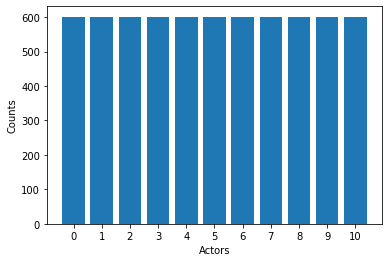

In [66]:
#Image augmentation and counts amount of images for each class
def augmentation_count():
  for i in range(len(x)):
    imgaug(i)
  for i in range(len(x)):
    occurrences = np.count_nonzero(y1 == i)
    #print(i, 'appered ', occurrences)
  distribution_train = {"0": np.count_nonzero(y1 == 0),"1":np.count_nonzero(y1 == 1),
                        "2":np.count_nonzero(y1 == 2),"3":np.count_nonzero(y1 == 3),"4":np.count_nonzero(y1 == 4),
                        "5":np.count_nonzero(y1 == 5),"6": np.count_nonzero(y1 == 6),"7": np.count_nonzero(y1 == 7),
                        "8": np.count_nonzero(y1 == 0),"9": np.count_nonzero(y1 == 9),"10": np.count_nonzero(y1 == 10),}
  plt.bar(list(distribution_train.keys()),list(distribution_train.values()),width =0.8)
  plt.xlabel('Actors')
  plt.ylabel('Counts')
  plt.show()
  
augmentation_count()

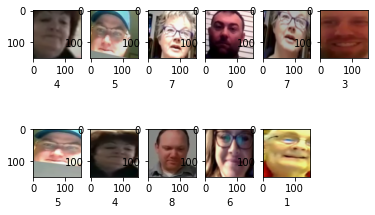

In [67]:
#Shuffle the dataset

x, y = shuffle(x1,y1)
for i in range(len(original_p)):
  plt.subplot(2,6,i+1)
  plt.imshow(x[i].reshape(150,150,3))
  plt.xlabel(y[i])
  
#Reshape them back to 150,150,3

arr = []
for i in range(len(x)):
    image = x[i].reshape(150,150,3)
    arr.append(image)
arr = np.array(arr)
x = arr

In [68]:
#Split the dataset

def split_dataset(x,y):
  train_split, val_split = 0.8, 0.10
  val_ind = int(train_split*len(x))
  test_idx = int((train_split + val_split)*len(x))
  train = x[:val_ind]
  val = x[val_ind:test_idx]
  test = x[test_idx:]
  #Let's have a validation set here by splitting the training set
  print("Training set")
  X_train, X_val, y_train,y_val = train_test_split(x,y,test_size = 1/10, random_state = 12)
  print(X_train.shape)
  #print(y_train)
  print(" ")
  print("Validation and Test set")
  X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size = 1/2, random_state = 12)
  print(X_val.shape,X_test.shape)
  #print(y_val,y_test)
  print('Images has been normalized')
  X_train = X_train.astype('float32') / 255.
  X_val = X_val.astype('float32') / 255.
  X_test = X_test.astype('float32') / 255.
  return X_train,X_val,X_test,y_train,y_val,y_test

X_train,X_val,X_test,y_train,y_val,y_test = split_dataset(x,y)

Training set
(5949, 150, 150, 3)
 
Validation and Test set
(331, 150, 150, 3) (331, 150, 150, 3)
Images has been normalized


In [69]:
#Plot the model's performance

def plots_model(history):
  fig = plt.figure()
  
  #fig.suptitle("Face Recognition Performance Graphs")
  ax = fig.add_subplot(1,2,1)
  ax.set_title("Cost")
  ax.plot(history.history['loss'], label="Training")
  ax.plot(history.history['val_loss'],label="Validation")
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  ax = fig.add_subplot(1,2,2)
  ax.set_title("Accuracy")
  ax.plot(history.history['accuracy'], label="Training")
  ax.plot(history.history['val_accuracy'],label="Validation")
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epochs')
  ax.legend()
  fig.suptitle("Face Recognition Performance Graphs", y=1,fontweight='bold')
  fig.tight_layout()
  plt.show()

In [70]:
#Import inn the vgg16 weights from imagenet with the input shape of 150,150,3
#output of 8 and activationfunction is softmax

def model_vgg16():
  vgg = VGG16(weights="imagenet",include_top=False, input_shape=(150,150,3))
  flatten = Flatten()
  new_layer2 = Dense(person_registered, activation='softmax', name='my_dense_2')
  #Adding the input and output layers
  inp2 = vgg.input
  out2 = new_layer2(flatten(vgg.output))
  model = Model(inp2, out2)
  #model.summary(line_length=150)
  for l, layer in enumerate(model.layers[:-1]):
    layer.trainable = False

  # ensure the last layer is trainable/not frozen
  for l, layer in enumerate(model.layers[-1:]):
    layer.trainable = True
  #model.summary()
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(X_train, y_train, 
                         batch_size=50, 
                         epochs=5, 
                         validation_data=(X_val, y_val))

  file_name = 'model_zoom_Class.h5'
  model.save(file_name)
  return model, history,file_name 

Epoch 1/5
119/119 [==============================] - 8s 64ms/step - loss: 0.2099 - accuracy: 0.9620 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 2/5
119/119 [==============================] - 7s 62ms/step - loss: 0.0197 - accuracy: 0.9985 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 3/5
119/119 [==============================] - 7s 62ms/step - loss: 0.0098 - accuracy: 0.9997 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/5
119/119 [==============================] - 7s 62ms/step - loss: 0.0064 - accuracy: 0.9998 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 5/5
119/119 [==============================] - 7s 62ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000


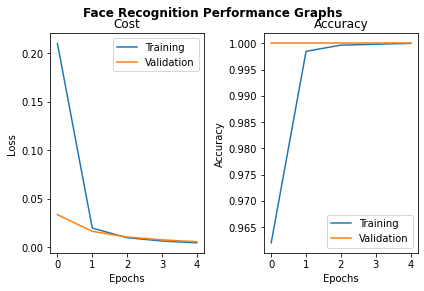

In [71]:
model,history,name = model_vgg16()
plots_model(history)

Test loss: 0.0050500622019171715
Test accuracy: 1.0


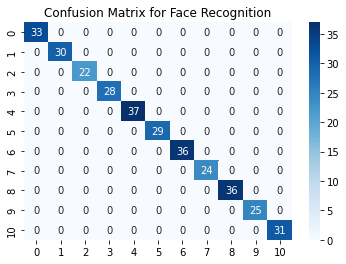

In [72]:
#Evaluate the model's performance based on test set and showcase 
#it with confusion matrix
def model_on_test(x_test,y_test):

  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

  print('Test loss:', loss)
  print('Test accuracy:', accuracy)

  predictions = model.predict(X_test)
  a = np.argmax(predictions,axis=1)

  cf_matrix = confusion_matrix(y_test, a)
  #print(cf_matrix)
  ax = plt.axes()
  sns.heatmap(cf_matrix, annot=True,  cmap='Blues')
  ax.set_title('Confusion Matrix for Face Recognition')
  plt.show()

model_on_test(X_test,y_test)

#Step two of the Emotion Logger

In [73]:
def Face_Emotion_Rec(path_emotion,path_video,model,names):

  model_emotion = load_model(path_emotion)
  model_face = model
  emotions = ['Angry','Fear','Happy','Neutral','Sad']
  emotions = np.array(emotions)
  names = np.array(names)

  video = cv2.VideoCapture(path_video)

  if (video.isOpened() == False):
      print("Error reading video file")

  frame_width = int(video.get(3))
  frame_height = int(video.get(4))

  size = (frame_width, frame_height)


  results_path = '/content/sample_data/Emotion_Logger_Video.avi'
  result = cv2.VideoWriter(results_path,cv2.VideoWriter_fourcc(*'MJPG'),29, size)
  frame_num=0
   

  listofemotions = []
  listofemotions1 = []
  frames = []
  listofnames = []
  print('Detecting faces......')

  while ((video.isOpened())):
      ret, frame = video.read()
      frame_num += 1
      if frame_num % 1000 == 0:
          print(f'Still working......... currently on, {frame_num}')
      elif frame_num % 9000 == 0:
          print('Almost done...........')
      frames.append(frame_num)
      if ret == True:
        if frame_num % 20 == 0:        #Change this from 20 if it is selfmade, 
                                       #else keep it as 15
            location = detector.detect_faces(frame)
            if len(location) > 0:
                for face in location:
                    face_loc = []
                    x, y, width, height = face['box']
                    x2, y2 = x + width, y + height
                    number = 30
                    number1 = -10
                    face_loc = [x,x2,y,y2]
                    face_loc = np.array(face_loc)
                    if np.min(face_loc) < 30:
                        number = np.min(face_loc)
                    else:
                        number = 30

                    image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                    image_shape = np.array(image[y:y2,x:x2].shape)

                    if np.max(image_shape) < 35:
                        print('Person face is not clear')
                    else:
                        image1 = cv2.resize(image[y-number:y2+number,x-number:x2+number],(150,150))
                        image2 = cv2.resize(image[y-number1:y2+number1,x-number1:x2+number1],(150,150))

                        font = cv2.FONT_HERSHEY_SIMPLEX

                        image1 = image1.astype('float32')/255
                        image1 = tf.reshape(image1, [1,150, 150,3])
                        image2 = image2.astype('float32')/255
                        image2 = tf.reshape(image2, [1,150, 150,3])

                        prediction = model_face.predict(image1)
                        a = np.argmax(prediction)

                        font = cv2.FONT_HERSHEY_SIMPLEX
                        prediction1 = model_emotion.predict(image2)
                        if np.max(prediction1) > 0.65:
                          a1 = np.argmax(prediction1)
                        else:
                          a1 = 3
                        org = (0, 50)
                        fontScale = 1
                        color = (255, 0, 0)
                        thickness = 2
                      
                        cv2.rectangle(frame, (x-number, y-number), (x2+number, y2+number), (0, 0, 255), 4)
                        cv2.putText(frame, str(names[a].split()[0]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 3)
                        cv2.putText(frame, str(emotions[a1]), (x2, y2-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 3)

                        listofemotions1.append(prediction1)
                        listofnames.append(names[a].split()[0])
                        listofemotions.append(emotions[a1])
            result.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
      #if frame_num == 200:
      #    break
      else:
          break

  if frame_num == 0:
    print('There was no frame detected, video will not display')
  else:
    print('In total there was' ,frame_num, " frames on this video")
    print("The video was successfully saved")
  video.release()
  result.release()

# Closes all the frames
  cv2.destroyAllWindows()

  return results_path,listofemotions,listofnames,listofemotions1


In [74]:
path_emotion = '/content/drive/MyDrive/Emotion_Rec_Model.h5'


#path_video = '/content/drive/MyDrive/Zoom_5min_1.mp4'       #Middle School Zoom
path_video = '/content/drive/MyDrive/Zoom_Old_5min.mp4'    #Old zoom
#path_video = '/content/drive/MyDrive/self_made_7min.mp4'   #Self_made  Class


model_1 = model
video_results,listofemotions,listofnames,listofemotions_1 = Face_Emotion_Rec(path_emotion,path_video,model_1,names)


Detecting faces......
Still working......... currently on, 1000
Still working......... currently on, 2000
Still working......... currently on, 3000
Still working......... currently on, 4000
Person face is not clear
Person face is not clear
Person face is not clear
Person face is not clear
Person face is not clear
Person face is not clear
Person face is not clear
Still working......... currently on, 5000
Person face is not clear
Still working......... currently on, 6000
Still working......... currently on, 7000
Still working......... currently on, 8000
Still working......... currently on, 9000
In total there was 9029  frames on this video
The video was successfully saved


In [75]:
#Runtime might disconnect here, but the file is saved in sample_data as an avi file

path=video_results
clip=VideoFileClip(path).subclip(0,20)
clip.ipython_display(width=10)

100%|█████████▉| 580/581 [00:09<00:00, 62.68it/s]


In [ ]:
#Display the video here 

path1 = '/content/__temp__.mp4'

play_video(path1)

## Create dataframe for emotion report 

In [77]:
def dataframe(listofnames,listofemotions):
  Emotions = listofemotions
  #Emotions = np.array((Emotions.dropna()))
  EmotionsInNumber = labelencoder.fit_transform(Emotions)
  EmotionsInNumber = np.array(EmotionsInNumber)
  colors = []
  for i in range(len(EmotionsInNumber)):
    if EmotionsInNumber[i] == 0:
      colors.append('blue')
    elif EmotionsInNumber[i] == 1:
      colors.append('red')
    elif EmotionsInNumber[i] == 2:
      colors.append('green')
    elif EmotionsInNumber[i] == 3:
      colors.append('black')
    elif EmotionsInNumber[i] == 4:
      colors.append('cyan')

  raw_data = {'Name': listofnames, 'Emotions': listofemotions,
              'Emotions_in_number': EmotionsInNumber, 'Colors': colors}
  df = pd.DataFrame(raw_data, columns = ['Name', 'Emotions','Emotions_in_number','Colors'])
  #LE = LabelEncoder()
  #df['Code'] = LE.fit_transform(df['Emotions'].tolist())
  df.head()
  print('Overall Description of the dataframe')
  print()
  print(df.describe())
  print()
  print()
  print('Overall Information of the dataframe')
  print()
  print(df.info())
  print()
  print()
  return df

In [78]:
Report = dataframe(listofnames,listofemotions)

Overall Description of the dataframe

       Emotions_in_number
count         4410.000000
mean             1.330612
std              1.556377
min              0.000000
25%              0.000000
50%              0.000000
75%              3.000000
max              4.000000


Overall Information of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                4410 non-null   object
 1   Emotions            4410 non-null   object
 2   Emotions_in_number  4410 non-null   int64 
 3   Colors              4410 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.9+ KB
None




In [79]:
Report.head()

,Name,Emotions,Emotions_in_number,Colors
0,Spenser,Sad,4,cyan
1,Mattie,Neutral,3,black
2,Madison,Neutral,3,black
3,Hawk,Angry,0,blue
4,Madison,Angry,0,blue


#Plotting the emotion development

In [80]:
def emotion_plot(Original_person,Original_label,dataframe_given, number):
  #names = ['Person0','Person1','Person3','Person4',
             #'Person5','Person6','Person7',
             #'Person8','Person9','Person10','Person2']
  names = Original_label
  person = names[number]
  #print(person)
  emotion = dataframe_given['Emotions_in_number'].where(dataframe_given['Name'] == person)
  emotion = emotion.dropna().tolist()

  #random_emotions = [0,0,0,0,0,0,0,1,2,3,2,1,2,1, 2,3,2,2,2,2,1,1,2,3,3,3,3,3,3,4, 4,4,4,4,2,1,2,2,1,2,3,4,0,0,0,0,0]
  random_emotions = emotion
  #print(random_emotions)
  df = pd.DataFrame({'val': random_emotions})
  emotion_dict = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad'}
  color_dict = {0: 'k', 1: 'r', 2: 'b', 3: 'y', 4: 'g'}
  df['emotion'] = df.val.map(emotion_dict)
  df['color'] = df.val.map(color_dict)


# everything else from here is a duplicated

  df['change'] = df.val.ne(df.val.shift().bfill()).astype(int)
  df['subgroup'] = df['change'].cumsum()

  df.index += df['subgroup'].values

  
  custom_lines = [Line2D([0], [0], color=color, lw=4) for color in color_dict.values()]
  plt.subplot(1,3,1)
  plt.imshow(Original_person[number])
  plt.xlabel(Original_label[number])
  plt.subplot(1,3,3)

  for i in range(5):
    occurrences = np.count_nonzero(np.array(random_emotions) == i)
  #print(i, 'appered ', occurrences)
    distribution_train = {"0": np.count_nonzero(np.array(random_emotions) == 0),"1":np.count_nonzero(np.array(random_emotions) == 1),
                          "2":np.count_nonzero(np.array(random_emotions) == 2),
                          "3":np.count_nonzero(np.array(random_emotions) == 3),"4":np.count_nonzero(np.array(random_emotions) == 4),}

    plt.bar(list(distribution_train.keys()),list(distribution_train.values()),width =0.3,color=color_dict.values())
    plt.xlabel('Emotions')
    plt.ylabel('Amount of Frame for that Emotion')
    plt.legend(handles = custom_lines, labels=list(emotions), bbox_to_anchor=(1, 1.02), loc='upper left')

  #plt.legend('Angry', 'Fear','Happy','Neutral','Sad')
  first_i_of_each_group = df[df['change'] == 1].index
  for i in first_i_of_each_group:
    # Copy next group's first row to current group's last row
      df.loc[i-1] = df.loc[i]
    # But make this new row part of the current group
      df.loc[i-1, 'subgroup'] = df.loc[i-2, 'subgroup']
# Don't need the change col anymore
  df.drop('change', axis=1, inplace=True)
  df.sort_index(inplace=True)
# Create duplicate indexes at each subgroup border to ensure the plot is continuous.
  df.index -= df['subgroup'].values

  fig, ax = plt.subplots(figsize=(10, 4))
  for k, g in df.groupby('subgroup'):
      g.plot(ax=ax, y='val', color=g['color'].values[0], marker='_', legend=False)#, xticks=df.index[::200])

  ax.margins(x=0)
  custom_lines = [Line2D([0], [0], color=color, lw=4) for color in color_dict.values()]
  ax.set_ylabel('Emotions')
  ax.set_xlabel('Frames')
  leg1 = ax.legend(handles=custom_lines, labels=emotion_dict.keys(), bbox_to_anchor=(1, 1.02), loc='upper left')
  #leg1 = ax.legend(loc='lower left')

  leg2 = ax.legend(handles=custom_lines, labels=emotion_dict.values(), bbox_to_anchor=(1.1, 1.02), loc='upper left')
  # Manually add the first legend back
  ax.add_artist(leg1)
  plt.show()
  return distribution_train

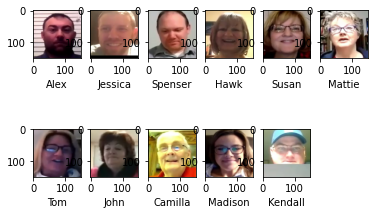

In [81]:
for i in range(len(original_l)):
  plt.subplot(2,6,i+1)
  plt.imshow(original_p[i])
  plt.xlabel(original_l[i])
plt.show()
#print(original_l)

['Alex' 'Jessica' 'Spenser' 'Hawk' 'Susan' 'Mattie' 'Tom' 'John' 'Camilla'
 'Madison' 'Kendall']
Which character do you want report on (to break out of loop press 12) 0
Emotion report for Alex will be generated


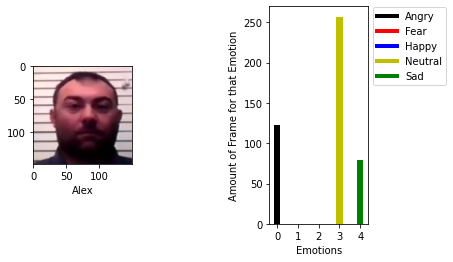

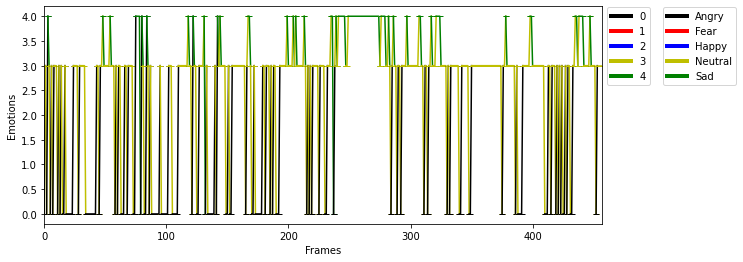

Which character do you want report on (to break out of loop press 12) 1
Emotion report for Jessica will be generated


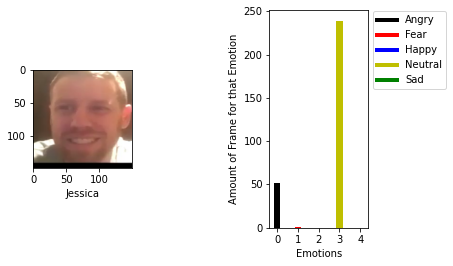

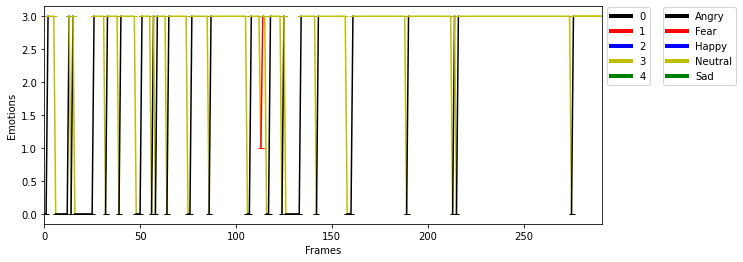

Which character do you want report on (to break out of loop press 12) 2
Emotion report for Spenser will be generated


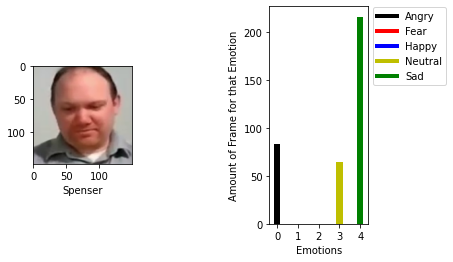

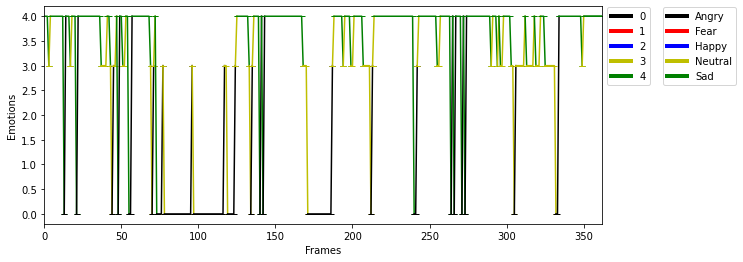

Which character do you want report on (to break out of loop press 12) 3
Emotion report for Hawk will be generated


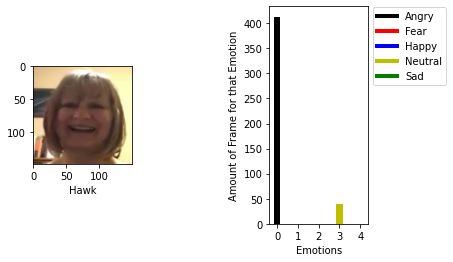

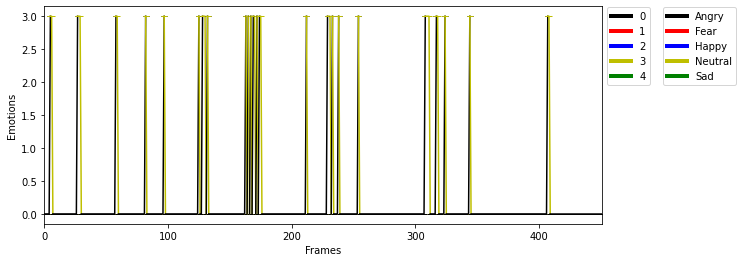

Which character do you want report on (to break out of loop press 12) 4
Emotion report for Susan will be generated


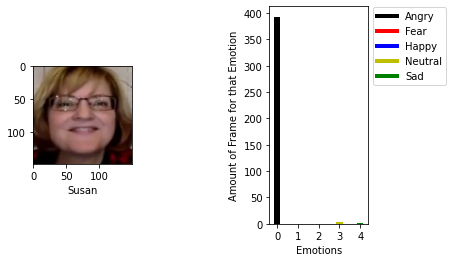

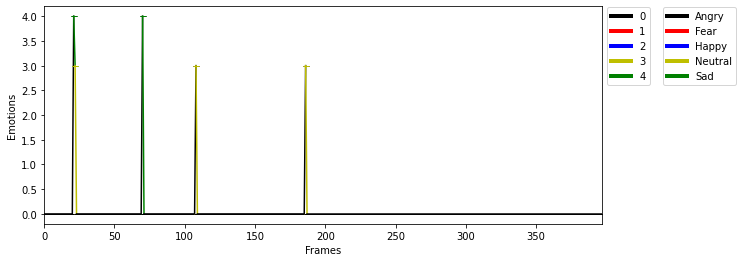

Which character do you want report on (to break out of loop press 12) 5
Emotion report for Mattie will be generated


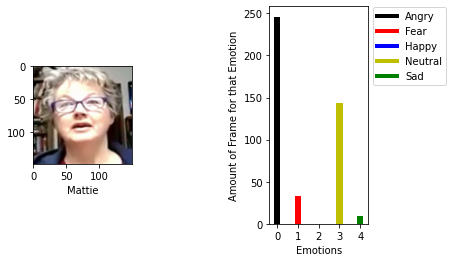

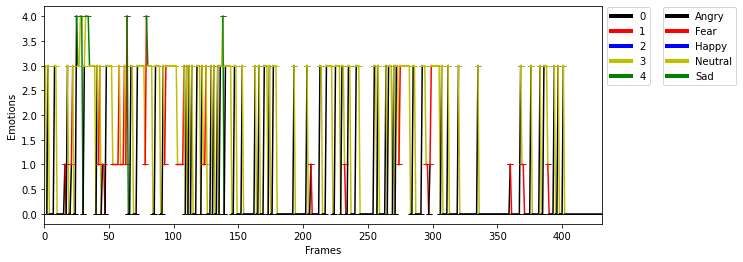

Which character do you want report on (to break out of loop press 12) 6
Emotion report for Tom will be generated


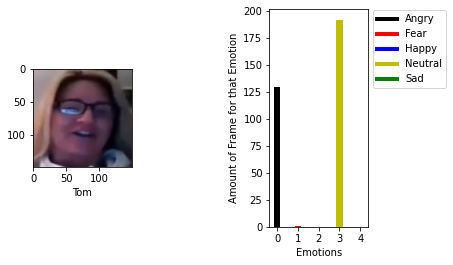

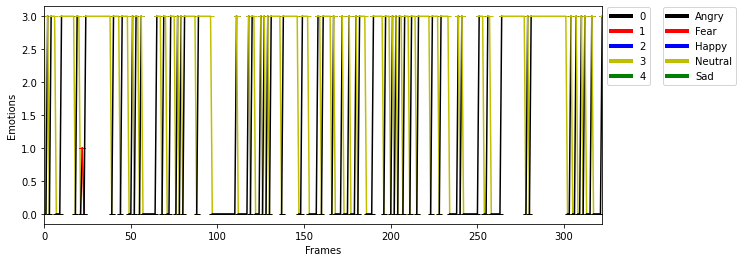

Which character do you want report on (to break out of loop press 12) 7
Emotion report for John will be generated


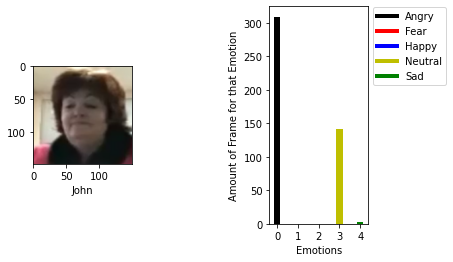

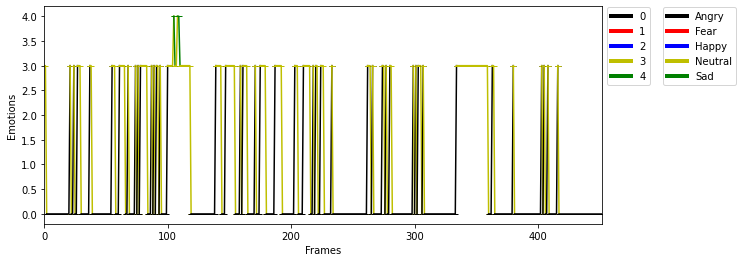

Which character do you want report on (to break out of loop press 12) 8
Emotion report for Camilla will be generated


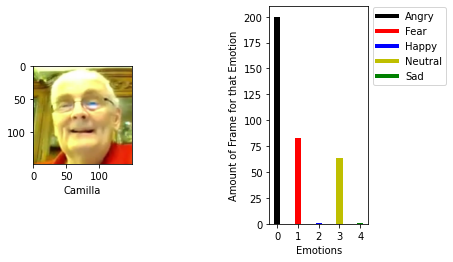

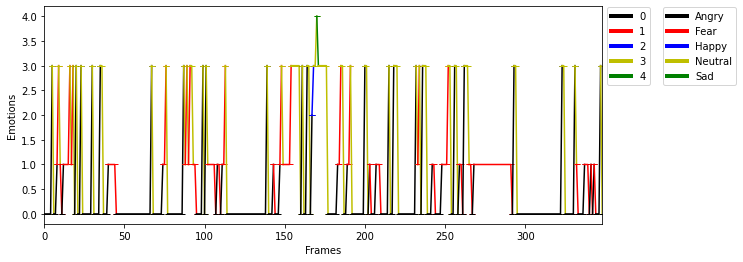

Which character do you want report on (to break out of loop press 12) 9
Emotion report for Madison will be generated


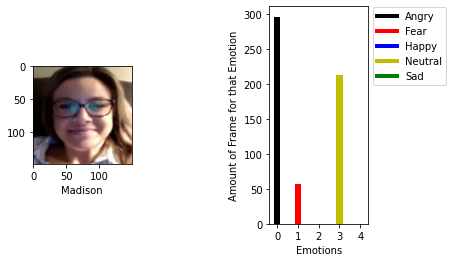

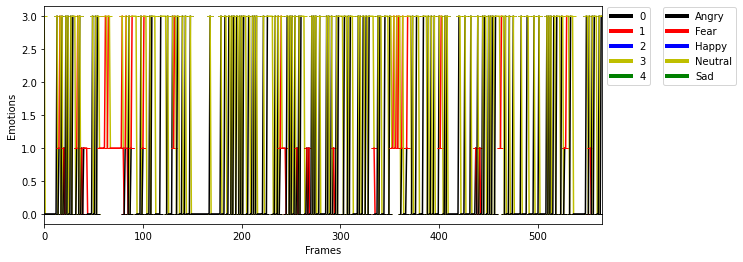

Which character do you want report on (to break out of loop press 12) 10
Emotion report for Kendall will be generated


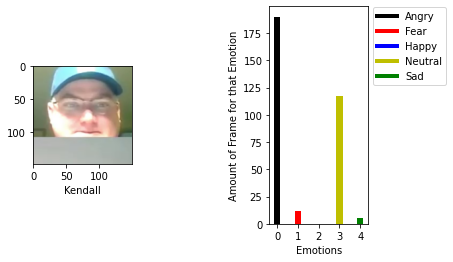

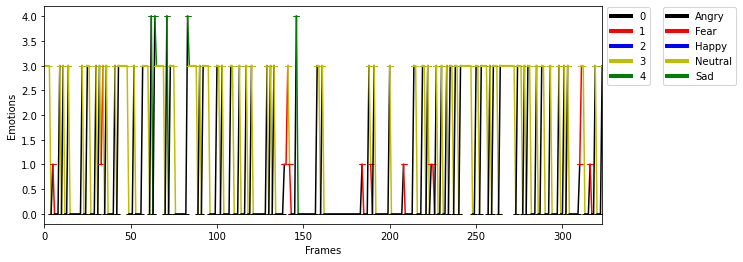

Which character do you want report on (to break out of loop press 12) 11
Stopping the Emotion Report


In [82]:
#names = original_l
print(original_l)

#print(np.array(list(range(0,len(names)))))


while True:

    try:
      name = int(((input("Which character do you want report on (to break out of loop press 12) "))))
    
      if name > 10 or name < 0:
          print('Stopping the Emotion Report')
          break
      print(f'Emotion report for {original_l[(name)]} will be generated')
      emotion_plot(original_p,original_l,Report,name)
    except:
      print('Error, given value is not within the range wanted')
      break 
    

In [57]:
Report.to_csv('Zoom_middle.csv', encoding='utf-8', index=False)